# Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer-learning: fine-tuning

## Creating helper functions

In previous notebooks, we have created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you will want to use again in a script you can download and import into your notebooks (or elsewhere).

We have done this for some of the functions we have used previously.

In [4]:
import sys
import os

# Subir dos niveles: desde notebooks/pruebas → mi_proyecto/
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

# Ahora puedes importar
from utils.helper_functions import create_tensorboard_callback, plot_loss_curves, walk_through_dir

## Let's get some data

This time we are going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

In [5]:
# Get 10% of training data of 10% of Food101 and check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [6]:
# Create training and test directory paths
train_dir = '10_food_classes_10_percent/train'
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Check out class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See and example of a batch of data
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[232.30103   225.30103   217.30103  ]
   [234.14795   230.14795   219.14795  ]
   [234.86736   232.86736   219.43878  ]
   ...
   [234.71431   236.64795   226.91833  ]
   [236.28572   237.28572   223.14284  ]
   [239.05614   237.6429    220.88261  ]]

  [[233.59694   229.59694   218.59694  ]
   [241.07143   237.07143   226.07143  ]
   [238.84183   236.84183   223.84183  ]
   ...
   [238.        239.9847    229.03061  ]
   [238.0051    238.0102    227.72446  ]
   [236.73976   237.47452   224.94897  ]]

  [[233.7347    231.7347    218.30612  ]
   [241.38266   237.81123   225.59694  ]
   [238.00511   234.7245    223.47958  ]
   ...
   [239.42853   239.        228.57147  ]
   [238.0153    239.0153    231.04593  ]
   [236.93364   239.71936   233.14793  ]]

  ...

  [[236.70917   234.4949    219.06638  ]
   [241.19896   239.19896   226.16835  ]
   [241.2908    241.33672   231.76529  ]
   ...
   [236.95409   237.        227.09181  ]
   [238.92856   238.92856   228.92856  ]
   [2

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.

In [11]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# 4. If using a model like ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)), # validate on a quarter
                                 callbacks=create_tensorboard_callback(dir_name='transfer_learning',
                                                                       experiment_name='10_percent_feature_extraction'))

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20250731-224253
Epoch 1/5
24/24 [==============================] - 13s 137ms/step - loss: 1.8843 - accuracy: 0.4093 - val_loss: 1.3445 - val_accuracy: 0.7336
Epoch 2/5
24/24 [==============================] - 2s 79ms/step - loss: 1.1454 - accuracy: 0.7680 - val_loss: 0.8863 - val_accuracy: 0.8405
Epoch 3/5
24/24 [==============================] - 2s 79ms/step - loss: 0.8243 - accuracy: 0.8333 - val_loss: 0.7057 - val_accuracy: 0.8520
Epoch 4/5
24/24 [==============================] - 2s 77ms/step - loss: 0.6817 - accuracy: 0.8587 - val_loss: 0.6165 - val_accuracy: 0.8586
Epoch 5/5
24/24 [==============================] - 2s 78ms/step - loss: 0.5879 - accuracy: 0.8693 - val_loss: 0.5433 - val_accuracy: 0.8799


In [12]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 3s 40ms/step - loss: 0.5685 - accuracy: 0.8552


[0.5685380697250366, 0.8551999926567078]

In [13]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [14]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   0           ['rescaling[0][0]']              
                                3)                                                

In [15]:
# How about a summary of our model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


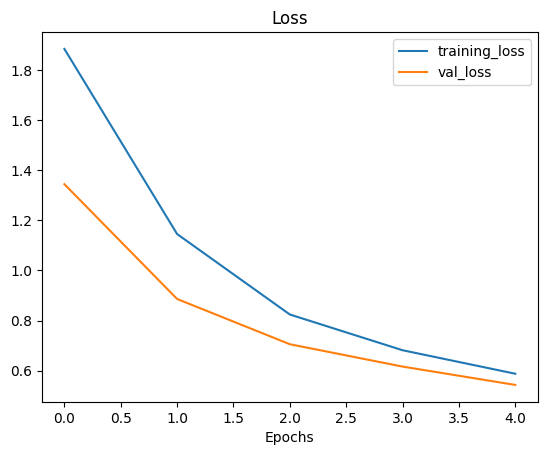

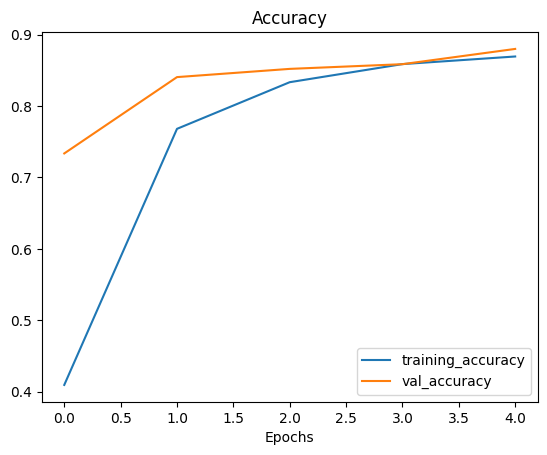

In [16]:
# Check out our model's training curves
plot_loss_curves(history=history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [17]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}\n')

# Pass the random tensor through a global average pooling 2D layer
gloabl_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D Global Average Pooled Random Tensor:\n {gloabl_average_pooled_tensor}\n')

# Check the shape of the different tensors
print(f'Shape of input tensors: {input_tensor.shape}')
print(f'Shape og 2D Global Average Pooled Tensor: {gloabl_average_pooled_tensor.shape}')

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D Global Average Pooled Random Tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensors: (1, 4, 4, 3)
Shape og 2D Global Average Pooled Tensor: (1, 3)


In [18]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

**Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens is pretrained models outputs a **feature vector** (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract patterns out of for our own specific problem.

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

**Note:** Throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

### Getting and preprocessing data for model 1

In [19]:
# Create training and test dirs
train_dir_1_percent = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [20]:
# How many images are we working with?
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [21]:
# Setup data loaders
IMF_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) # default = 32

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

Off the top of our heads, after reading the docs, the benefits of using data augmentation inside the model are:

* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers # type: ignore
from tensorflow.keras.layers.experimental import preprocessing # type: ignore

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
    # preprocessing.Rescaling(1./255) # Keep for models like ResNet50V2
], name='data_augmentation')

### Visualize our data augmentation layer and see what happens to our data

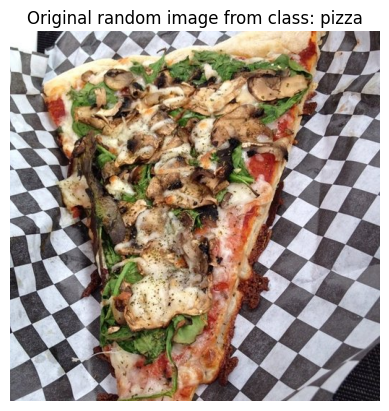

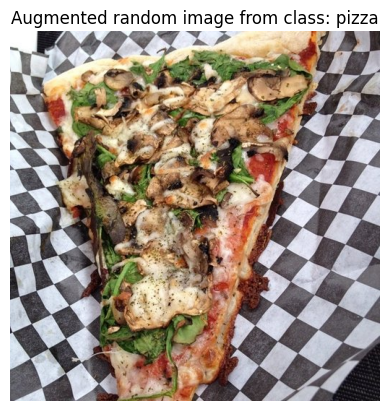

In [23]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = '10_food_classes_1_percent/train/' + target_class

random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image

# Read and plot in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f'Original random image from class: {target_class}')
plt.axis('off')
plt.show()

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f'Augmented random image from class: {target_class}')
plt.axis('off');

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [24]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name='input_layer')

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name='gloabl_average_pooling_layer')(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                       experiment_name='1_percent_data_aug')])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20250731-224321
Epoch 1/5
3/3 [==============================] - 9s 1s/step - loss: 2.4197 - accuracy: 0.1143 - val_loss: 2.3917 - val_accuracy: 0.0970
Epoch 2/5
3/3 [==============================] - 1s 569ms/step - loss: 2.1846 - accuracy: 0.1714 - val_loss: 2.2589 - val_accuracy: 0.1760
Epoch 3/5
3/3 [==============================] - 1s 557ms/step - loss: 2.0400 - accuracy: 0.2714 - val_loss: 2.1442 - val_accuracy: 0.2204
Epoch 4/5
3/3 [==============================] - 1s 554ms/step - loss: 1.8709 - accuracy: 0.3857 - val_loss: 2.0519 - val_accuracy: 0.2911
Epoch 5/5
3/3 [==============================] - 1s 566ms/step - loss: 1.7438 - accuracy: 0.5714 - val_loss: 1.9570 - val_accuracy: 0.3635


In [25]:
# Check out a model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 gloabl_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [26]:
# Evaluate on the full test set
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 3s 40ms/step - loss: 1.9550 - accuracy: 0.3604


[1.9549740552902222, 0.36039999127388]

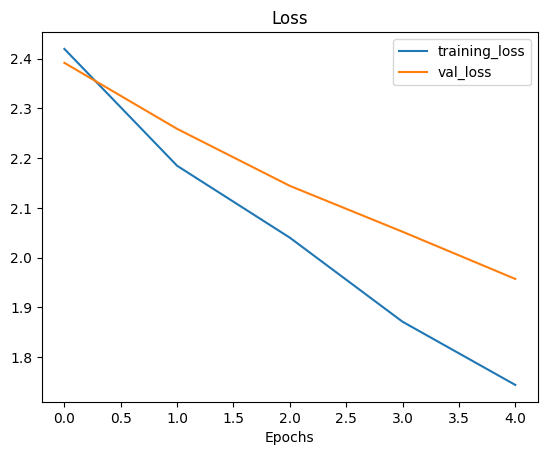

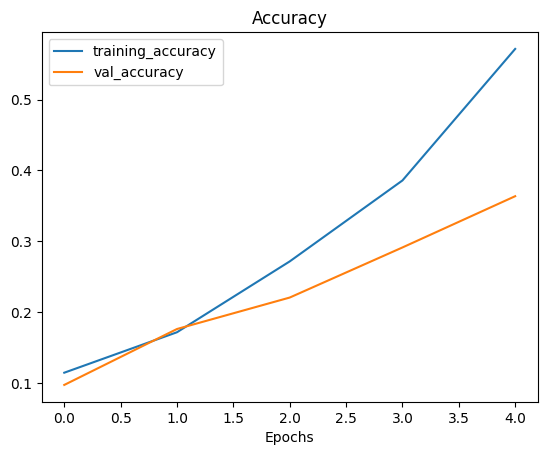

In [27]:
# How does the model go with data augmentation on the loss curves?
plot_loss_curves(history_1_percent)

## Model 2: Feature Extraction transfer learning model with 10% of data with data augmentation

In [28]:
train_dir_10_percent = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [29]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode='categorical',
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [30]:
# How many images are in our directories?
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [31]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
], name='data_augmentation')

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in beteween)
inputs = layers.Input(shape=input_shape, name='input_layer')

x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to our base model
x = layers.GlobalAveragePooling2D(name='gloabl_average_pooling_2D')(x)
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weigths) during training. This is useful so we can come and start where we left oft.

In [32]:
# Set checkpoint path
checkpoint_path = '10_percent_model_checkpoint_weights/checkpoint.ckpt'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch',
                                                         verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [33]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                 experiment_name='10_percent_data_aug'),
                                                    checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20250731-224342
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0148 - accuracy: 0.3413
Epoch 1: saving model to 10_percent_model_checkpoint_weights\checkpoint.ckpt
24/24 [==============================] - 14s 312ms/step - loss: 2.0148 - accuracy: 0.3413 - val_loss: 1.4838 - val_accuracy: 0.6414
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3770 - accuracy: 0.6773
Epoch 2: saving model to 10_percent_model_checkpoint_weights\checkpoint.ckpt
24/24 [==============================] - 6s 257ms/step - loss: 1.3770 - accuracy: 0.6773 - val_loss: 1.0688 - val_accuracy: 0.7401
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0639 - accuracy: 0.7547
Epoch 3: saving model to 10_percent_model_checkpoint_weights\checkpoint.ckpt
24/24 [==============================] - 6s 259ms/step - loss: 1.0639 - accuracy: 0.7547 - val_loss: 0.8603 - val_accuracy: 0.7796
Epoch 4/5

In [34]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 4s 40ms/step - loss: 0.5685 - accuracy: 0.8552


[0.5685381293296814, 0.8551999926567078]

In [35]:
# Check model_2 results on all test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 3s 41ms/step - loss: 0.6340 - accuracy: 0.8420


[0.6340281367301941, 0.8420000076293945]

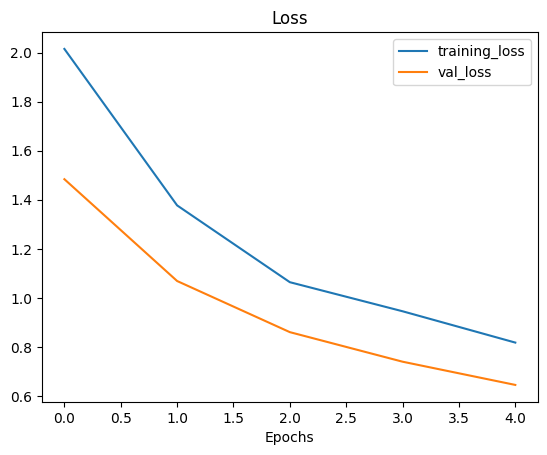

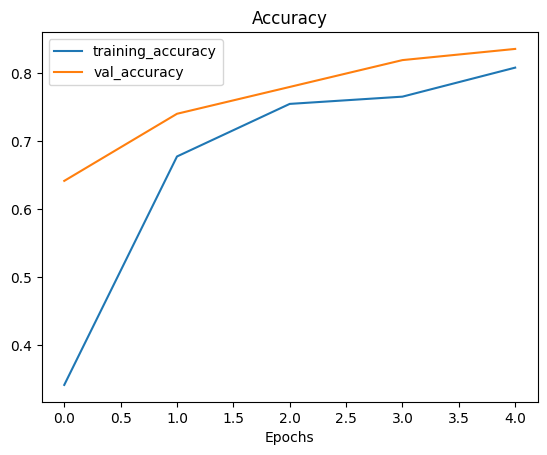

In [36]:
# Plot model loss curves
plot_loss_curves(history=history_10_percent_data_aug)

### Loading in checkpointed weigths

Loading in checkpointed weigths returns a model to a specific checkpoint.

In [37]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [38]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 3s 40ms/step - loss: 0.6340 - accuracy: 0.8420


In [39]:
# If the results from our previously evaluated model_2 match the loaded weights, every
results_10_percent_data_aug == loaded_weights_model_results

True

In [40]:
results_10_percent_data_aug

[0.6340281367301941, 0.8420000076293945]

In [41]:
loaded_weights_model_results

[0.6340281367301941, 0.8420000076293945]

In [42]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [43]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[0. 0.]


## Model 3: Fine-tuning an existing model on 10% of the data

**Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [44]:
# Layer in loaded model
model_2.layers

In [45]:
# Are theses layers trainable:
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x00000189650B2CE0> True
<keras.engine.sequential.Sequential object at 0x0000018964FA5270> True
<keras.engine.functional.Functional object at 0x00000189650B0970> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x0000018964FA6AD0> True
<keras.layers.core.dense.Dense object at 0x000001896C2E20B0> True


In [46]:
# What layers are in our base_model and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [47]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [48]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable=False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning you typically want to lower the learning rate by 10x*
                metrics=['accuracy'])

**Note:** When using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is an hyperparameter you can tune. But a good rule of thum is at least 10x (thoug different sources will claim other values).

In [49]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [50]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [51]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start training from previous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                      experiment_name='10_percent_fine_tune_last_10')]) 

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20250731-224432
Epoch 5/10
24/24 [==============================] - 13s 276ms/step - loss: 0.6747 - accuracy: 0.8267 - val_loss: 0.5589 - val_accuracy: 0.8273
Epoch 6/10
24/24 [==============================] - 6s 228ms/step - loss: 0.5734 - accuracy: 0.8387 - val_loss: 0.5118 - val_accuracy: 0.8355
Epoch 7/10
24/24 [==============================] - 6s 229ms/step - loss: 0.5524 - accuracy: 0.8307 - val_loss: 0.5048 - val_accuracy: 0.8388
Epoch 8/10
24/24 [==============================] - 6s 228ms/step - loss: 0.5113 - accuracy: 0.8360 - val_loss: 0.4834 - val_accuracy: 0.8503
Epoch 9/10
24/24 [==============================] - 6s 230ms/step - loss: 0.4569 - accuracy: 0.8573 - val_loss: 0.4601 - val_accuracy: 0.8553
Epoch 10/10
24/24 [==============================] - 5s 222ms/step - loss: 0.4797 - accuracy: 0.8520 - val_loss: 0.4478 - val_accuracy: 0.8569


In [52]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 3s 40ms/step - loss: 0.4389 - accuracy: 0.8548


In [53]:
results_10_percent_data_aug

[0.6340281367301941, 0.8420000076293945]

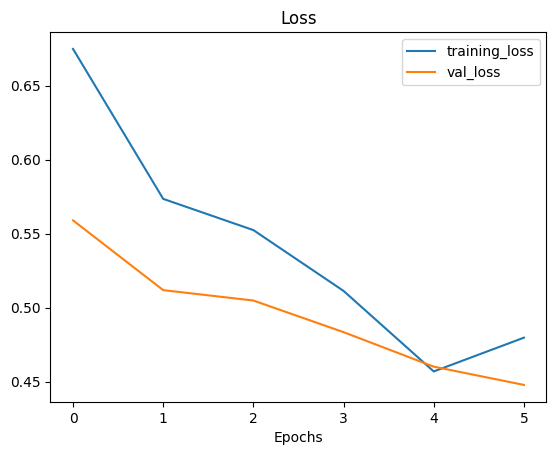

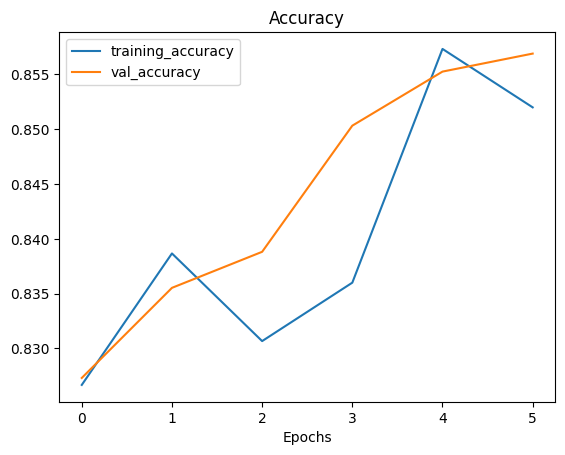

In [54]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once ,however, we want something to compare on series of running `fit()` with another (e.g. before and after fine-tuning).

In [55]:
#Let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs=5):
    """
    Compare two TensorFlow History object.
    """
    # Get original history measurements
    acc = original_history.history['accuracy']
    loss = original_history.history['loss']
    
    val_acc = original_history.history['val_accuracy']
    val_loss = original_history.history['val_loss']

    # Combine original history metrics with new_history metrics
    total_acc = acc + new_history.history['accuracy']
    total_loss = loss + new_history.history['loss']
    
    total_val_acc = acc + new_history.history['val_accuracy']
    total_val_loss = loss + new_history.history['val_loss']

    # Make plot for accuracu
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label = 'Validation Accuracy')
    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.show()

    # Make plot for loss
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label = 'Validation Loss')
    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

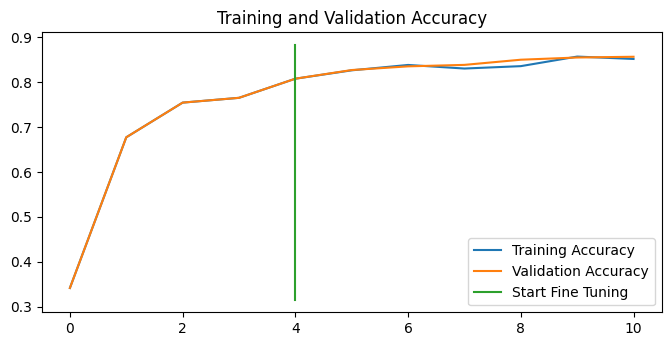

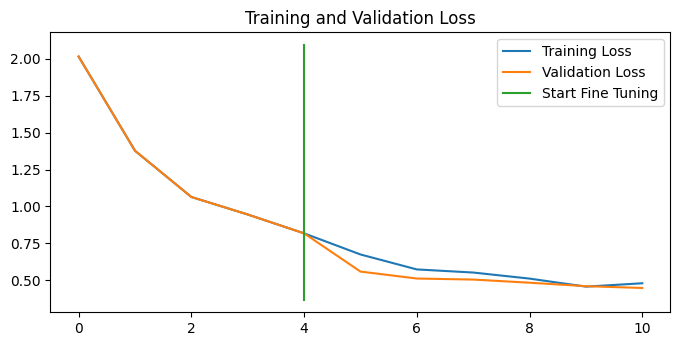

In [56]:
compare_histories(history_10_percent_data_aug,
                  history_fine_10_percent_data_aug,
                  initial_epochs=5)

## Model 4: Fine-tuning an existing model on all of the data

In [57]:
# Setup training and test dir
train_dir_all_data = '10_food_classes_all_data/train'
test_dir = '10_food_classes_all_data/test'

In [60]:
# How many images are we working with now?
walk_through_dir('10_food_classes_all_data')

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data\test'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\steak'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\sushi'.
There are 

In [62]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode='categorical',
                                                                                 image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we have loaded in is the same as what we have been using for previous experimetns (all experimetns have used the same test dataset).

Let's verify this...

In [63]:
# Evaluate model 2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 4s 44ms/step - loss: 0.4389 - accuracy: 0.8548


[0.438859224319458, 0.8547999858856201]

In [64]:
results_fine_tune_10_percent

[0.43885985016822815, 0.8547999858856201]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights.

In [65]:
# Load weights from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [66]:
# let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 4s 40ms/step - loss: 0.6340 - accuracy: 0.8420


[0.6340281963348389, 0.8420000076293945]

In [67]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6340281367301941, 0.8420000076293945]

Alright, the previous steps might seem quite confusing but all we have done is:

1. Trained a feature extraction transfer klearning model for 5 epochs on 10% of teh data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. Saved teh results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we are going to use all of the data (model_4).

In [68]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 True
3 gloabl_average_pooling_2D True
4 output_layer True


In [69]:
# Let's drill into our base_model (efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 